In [1]:
"""Imports"""
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

from miditok import REMI, TokenizerConfig
from miditok.pytorch_data import DatasetMIDI, DataCollator
from miditok.utils import split_files_for_training
from pathlib import Path
from random import shuffle, seed as random_seed
from torch.utils.data import DataLoader
from torchmetrics import Accuracy, Precision, Recall, F1Score, ConfusionMatrix
from torchmetrics.classification import MulticlassConfusionMatrix

/home/poppop/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
"""Set seeds and device"""
random_seed(73)
np.random.seed(73)
torch.manual_seed(73)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(73)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


Prepare Data for LSTM architecture

In [33]:
"""Train new tokenizer based on all augmented data"""
DATA_PATH = Path(Path.cwd().parent, "Data")
midi_paths = list(Path(DATA_PATH, "Augmented").glob(f"**/*.mid"))

config = TokenizerConfig(use_chords=True, use_rests=True, use_tempos=True, use_programs=True, one_token_stream_for_programs=False)
tokenizer = REMI(config)
tokenizer.train(vocab_size=500, files_paths=midi_paths)

tokenizer.is_trained
# NOTE: The vocab_size is a hyperparameter we could play with for optimization

True

In [35]:
"""Split into train/valid/test datasets using roughly 15% of the data for each of valid and test"""
total_num_files = len(midi_paths)
num_files_valid = round(total_num_files * 0.15)
num_files_test = round(total_num_files * 0.15)
shuffle(midi_paths)
midi_paths_valid = midi_paths[:num_files_valid]
midi_paths_test = midi_paths[num_files_valid:num_files_valid + num_files_test]
midi_paths_train = midi_paths[num_files_valid + num_files_test:]

for files_paths, subset_name in (
    (midi_paths_train, "Train"), (midi_paths_valid, "Validate"), (midi_paths_test, "Test")
):
    subset_chunks_dir = Path(DATA_PATH, "LSTM", subset_name)
    split_files_for_training(
        files_paths=files_paths,
        tokenizer=tokenizer,
        save_dir=subset_chunks_dir,
        max_seq_len=1024,
        num_overlap_bars=2,
    )

Splitting music files (/home/poppop/Classes/USD/Courses/2025 - Summer/AAI-511 Neural Networks and Deep Learning/Week 7/Final Project/su25-aai511-group6/Data/LSTM/Train): 100%|██████████| 280/280 [00:00<00:00, 864.09it/s]
Splitting music files (/home/poppop/Classes/USD/Courses/2025 - Summer/AAI-511 Neural Networks and Deep Learning/Week 7/Final Project/su25-aai511-group6/Data/LSTM/Validate): 100%|██████████| 60/60 [00:00<00:00, 1005.11it/s]
Splitting music files (/home/poppop/Classes/USD/Courses/2025 - Summer/AAI-511 Neural Networks and Deep Learning/Week 7/Final Project/su25-aai511-group6/Data/LSTM/Test): 100%|██████████| 60/60 [00:00<00:00, 988.33it/s]


In [ ]:
"""Create torch compatable data loaders using the datasets created above"""
#TODO See if we can make padding happen in the dataloader itself instead of needing to pad the data generated by the data loader
class Capture:
	def __init__(self):
		self.score = None
		self.tok_sequence = None
	
	def lable_composer(self, score, tok_sequence, file_path):
		self.score = score
		self.tok_sequence = tok_sequence
		composer = file_path.parts[-2:-1]
		if "Bach" in composer:
			return [1,0,0,0]
		elif "Beethoven" in composer:
			return [0,1,0,0]
		elif "Chopin" in composer:
			return [0,0,1,0]
		elif "Mozart" in composer:
			return [0,0,0,1]
		else:
			return [0,0,0,0]
		
capture = Capture()
collator = DataCollator(tokenizer.pad_token_id)

dataset_train = DatasetMIDI(
    files_paths=list(Path(DATA_PATH, "LSTM", "Train").glob("**/*.mid")),
    tokenizer=tokenizer,
    max_seq_len=1024,
    bos_token_id=tokenizer["BOS_None"],
    eos_token_id=tokenizer["EOS_None"],
    func_to_get_labels=capture.lable_composer
)
dataloader_train = DataLoader(dataset_train, batch_size=12, collate_fn=collator, shuffle=True)

dataset_valid = DatasetMIDI(
    files_paths=list(Path(DATA_PATH, "LSTM", "Validate").glob("**/*.mid")),
    tokenizer=tokenizer,
    max_seq_len=1024,
    bos_token_id=tokenizer["BOS_None"],
    eos_token_id=tokenizer["EOS_None"],
	func_to_get_labels=capture.lable_composer
)
dataloader_valid = DataLoader(dataset_valid, batch_size=12, collate_fn=collator, shuffle=True)

dataset_test = DatasetMIDI(
    files_paths=list(Path(DATA_PATH, "LSTM", "Test").glob("**/*.mid")),
    tokenizer=tokenizer,
    max_seq_len=1024,
    bos_token_id=tokenizer["BOS_None"],
    eos_token_id=tokenizer["EOS_None"],
	func_to_get_labels=capture.lable_composer
)
dataloader_test = DataLoader(dataset_test, batch_size=12, collate_fn=collator)

Build Model

In [80]:
"""LSTM definition"""
class ComposerLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0):
        super(ComposerLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                            batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        h_0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c_0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h_0, c_0))  # out: [batch, seq_len, hidden]
        out = out[:, -1, :]  # Take last timestep
        out = nn.functional.relu(self.fc1(out))
        return self.fc2(out)

Train Model

In [ ]:
"""Define training loop for LSTM"""
def train(model, training, validation, lr=0.001):
	criterion = nn.MSELoss()
	optimizer = torch.optim.Adam(model.parameters(), lr=lr)
	
	train_losses = []
	for data in training:
		inputs = data["input_ids"]
		input_padding = 12 - inputs.size()[0], 1024 - inputs.size()[1]
		padded_inputs = nn.functional.pad(input=inputs, pad=(input_padding[1], 0, input_padding[0], 0), mode='constant', value=-1)
		inputs = padded_inputs.reshape(12, 1, 1024).type(torch.float32)

		labels = data["labels"]
		label_padding = 12 - labels.size()[0], 4 - labels.size()[1]
		padded_labels = nn.functional.pad(input=labels, pad=(label_padding[1], 0, label_padding[0], 0), mode='constant', value=-1)
		labels = padded_labels.float()
		
		model.train()
		optimizer.zero_grad()
		output = model(inputs)
		loss = criterion(output, labels)
		loss.backward()
		optimizer.step()
		train_losses.append(loss.item())


	validation_losses = []
	with torch.no_grad():
		for v_data in validation:
			v_inputs = v_data["input_ids"]
			v_input_padding = 12 - v_inputs.size()[0], 1024 - v_inputs.size()[1]
			v_padded_inputs = nn.functional.pad(input=v_inputs, pad=(v_input_padding[1], 0, v_input_padding[0], 0), mode='constant', value=-1)
			v_inputs = v_padded_inputs.reshape(12, 1, 1024).type(torch.float32)

			v_labels = data["labels"]
			v_label_padding = 12 - v_labels.size()[0], 4 - v_labels.size()[1]
			v_padded_labels = nn.functional.pad(input=v_labels, pad=(v_label_padding[1], 0, v_label_padding[0], 0), mode='constant', value=-1)
			v_labels = v_padded_labels.float()

			model.eval()
			v_output = model(v_inputs)
			validation_loss = criterion(v_output, v_labels)	
			validation_losses.append(validation_loss.item())

	return train_losses, validation_losses

# Train LSTM model
epochs = 100
model = ComposerLSTM(input_size=1024, hidden_size=4096, num_layers=1, num_classes=4)

total_train_losses = []
total_validation_losses = []

for epoch in range(epochs):
	epoch_train_loss, epoch_validation_loss = train(model, dataloader_train, dataloader_valid)
	total_train_losses.extend(epoch_train_loss)
	total_validation_losses.extend(epoch_validation_loss)
	if (epoch + 1) % 10 == 0:
		print(f"Epoch {epoch + 1}, train loss: {total_train_losses[-1]:.4f}, validation loss: {total_validation_losses[-1]:.4f}")

Note: LSTM takes a long time to train.  The padding happening inside the loop certainly plays a role but there are likely other issues at play as well.

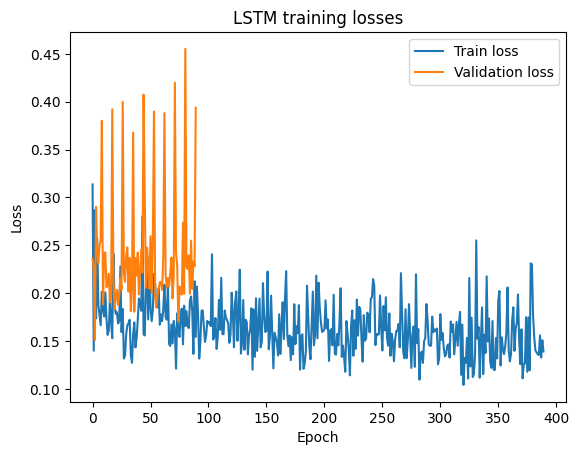

In [75]:
"""Plot training and validation losses"""
# TODO: Not sure why the training and validation quatities are not the same..
plt.title("LSTM training losses")
plt.ylabel("Loss")
plt.xlabel("Epoch")

plt.plot(total_train_losses, label="Train loss")
plt.plot(total_validation_losses, label="Validation loss")
plt.legend()
plt.show()

Evaluate Model

**NOTE**

Nothing below this line has been tested, adjustments are likely needed to work get it all working properly

In [93]:
"""Create tensors to use in performance metric creation"""
prediction = torch.Tensor()
truth = torch.Tensor()

with torch.no_grad():
    for data in dataloader_test:
        inputs = data["input_ids"]
        input_padding = 12 - inputs.size()[0], 1024 - inputs.size()[1]
        padded_inputs = nn.functional.pad(input=inputs, pad=(input_padding[1], 0, input_padding[0], 0), mode='constant', value=-1)
        inputs = padded_inputs.reshape(12, 1, 1024).type(torch.float32)
        
        labels = data["labels"]
        label_padding = 12 - labels.size()[0], 4 - labels.size()[1]
        padded_labels = nn.functional.pad(input=labels, pad=(label_padding[1], 0, label_padding[0], 0), mode='constant', value=-1)
        labels = padded_labels.float().view(12, -1).argmax(1).view(-1, 1).flatten()
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        prediction = torch.cat([prediction, predicted], dim=0)
    
        truth = torch.cat([truth, labels], dim=0)
        
assert prediction.shape == truth.shape 
print(prediction.shape)

torch.Size([108])


In [94]:
"""Create performance metrics"""
accuracy = Accuracy(task="multiclass", num_classes=32)
precision = Precision(task="multiclass", average="macro", num_classes=32)
recall = Recall(task="multiclass", average="macro", num_classes=32)
f1_score = F1Score(task="multiclass", average="macro", num_classes=32)
confusion_matric = ConfusionMatrix(task="multiclass", num_classes=32)

calculated_accuracy = accuracy(truth, prediction)
calculated_precision = precision(truth, prediction)
calculated_recall = recall(truth, prediction)
calculated_f1_score = f1_score(truth, prediction)
calculated_confusion_matric = confusion_matric(truth, prediction)

print("Model Accuracy:", calculated_accuracy)
print("Model Precision:", calculated_precision)
print("Model Recall:", calculated_recall)
print("Model F1:", calculated_f1_score)

Model Accuracy: tensor(0.3796)
Model Precision: tensor(0.3772)
Model Recall: tensor(0.2854)
Model F1: tensor(0.3001)


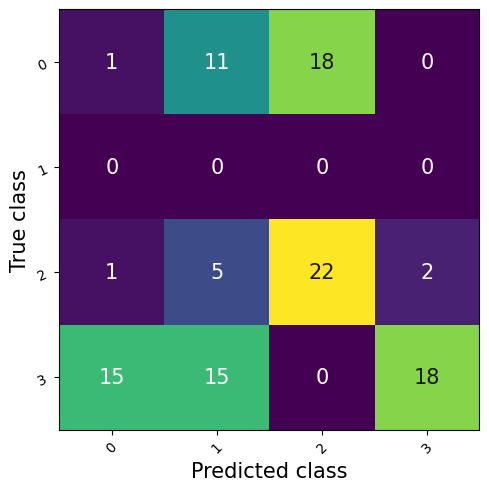

In [95]:
"""Vizulaize confusion matrix"""
metric = MulticlassConfusionMatrix(num_classes=4)
metric.update(truth, prediction)
fig_, ax_ = metric.plot()

Optimize hyperparameters

In [ ]:
#TODO: play with the parameters and optimize the CNN architecture